# Try CGF! Test run is on a point in time where there's an eddy parked in the beam

In [1]:
import sys
sys.path.append("/home/149/ab8992/tasman-tides/")
import xarray as xr
import ttidelib as tt
import scipy
import cmocean
import os
cmap = cmocean.cm.dense_r
import matplotlib
import matplotlib.pyplot as plt
earth_cmap = matplotlib.cm.get_cmap("gist_earth")
from datetime import timedelta
import filtering
import numpy as np
import dask
from dask.distributed import Client,default_client



def startdask():
    try:
    # Try to get the existing Dask client
        client = default_client()
        print(client)
    except ValueError:
        # If there's no existing client, create a new one
        client = Client()
        print(client)
    return client

client = startdask()


t0 = 44900 # Time in the middle of the window to be filtered
time_window = 100 # How many hours either side of t0 to consider
filter_window = 5 # How many hours either side of t0 to actually filter (subset of time window)
zl = 5
expt = "full-20"
filter_cutoff = 2*np.pi/(12.42*3600)
outpath = "/g/data/nm03/ab8992/postprocessed/full-20/waves"

/jobfs/110158870.gadi-pbs/ipykernel_1825424/1867067959.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  earth_cmap = matplotlib.cm.get_cmap("gist_earth")
sh: None: command not found
INFO: Compiled ParcelsRandom ==> /jobfs/110158870.gadi-pbs/parcels-16078/libparcels_random_11fcc7bb-d68b-4f4e-a264-f31d4efd19a8.so


<Client: 'tcp://127.0.0.1:33307' processes=7 threads=28, memory=112.00 GiB>


In [15]:
xr.open_mfdataset(tmpstorage + f"/uv_*.nc")

<xarray.Dataset>
Dimensions:  (xb: 376, yb: 101, time: 201)
Coordinates:
    zl       float64 ...
  * xb       (xb) float64 -0.0 4e+03 8e+03 ... 1.492e+06 1.496e+06 1.5e+06
  * yb       (yb) float64 -2e+05 -1.96e+05 -1.92e+05 ... 1.92e+05 1.96e+05 2e+05
  * time     (time) float64 1.613e+08 1.613e+08 1.613e+08 ... 1.62e+08 1.62e+08
Data variables:
    UV       (time, yb, xb) float32 dask.array<chunksize=(201, 101, 376), meta=np.ndarray>

In [14]:
xr.open_mfdataset(tmpstorage + f"/uu_*.nc")


<xarray.Dataset>
Dimensions:  (xb: 376, yb: 101, time: 201)
Coordinates:
    zl       float64 ...
  * xb       (xb) float64 -0.0 4e+03 8e+03 ... 1.492e+06 1.496e+06 1.5e+06
  * yb       (yb) float64 -2e+05 -1.96e+05 -1.92e+05 ... 1.92e+05 1.96e+05 2e+05
  * time     (time) float64 1.613e+08 1.613e+08 1.613e+08 ... 1.62e+08 1.62e+08
Data variables:
    UU       (time, yb, xb) float32 dask.array<chunksize=(201, 101, 376), meta=np.ndarray>

## First read in a single that overlaps the eddy

In [34]:
# tmpstorage = os.getenv('PBS_JOBFS')

# rawdata = tt.collect_data(
#     expt,
#     rawdata = ["u","v"],
#     timerange=(t0 - time_window,t0 + time_window)).isel(zl = zl)
# rawdata.u.attrs = {}
# rawdata.v.attrs = {}
# rawdata.zl.attrs = {}
# rawdata.time.attrs = {}
# rawdata.yb.attrs = {}
# rawdata.xb.attrs = {}



# rawdata = rawdata.assign_coords({
#     "time":rawdata.time * 3600,
#     "xb":rawdata.xb * 1000,
#     "yb":rawdata.yb * 1000})
# rawdata = rawdata.drop(["bathy","lat","lon"])

# print("Saving data to temporary storage")
# if "zl" in rawdata.dims:
#     for i in range(0,rawdata.dims["zl"]):
#         rawdata.u.isel(zl = i).to_netcdf(tmpstorage + f"/u_{i}.nc",mode="w")
#         rawdata.v.isel(zl = i).to_netcdf(tmpstorage + f"/v_{i}.nc",mode="w")
#         (rawdata.v**2).isel(zl = i).rename("vv").to_netcdf(tmpstorage + f"/vv_{i}.nc",mode="w")
#         (rawdata.u**2).isel(zl = i).rename("uu").to_netcdf(tmpstorage + f"/uu_{i}.nc",mode="w")
#         (rawdata.u*rawdata.v).rename("uv").isel(zl = i).to_netcdf(tmpstorage + f"/uv_{i}.nc",mode="w")
# else:
#     rawdata.u.to_netcdf(tmpstorage + f"/u_0.nc",mode="w")
#     rawdata.v.to_netcdf(tmpstorage + f"/v_0.nc",mode="w")
#     (rawdata.v**2).rename("vv").to_netcdf(tmpstorage + f"/vv_0.nc",mode="w")
#     (rawdata.u**2).rename("uu").to_netcdf(tmpstorage + f"/uu_0.nc",mode="w")
#     (rawdata.u*rawdata.v).rename("uv").to_netcdf(tmpstorage + f"/uv_0.nc",mode="w")
# print("done")
# client.close()
if os.path.exists(outpath + ".nc"):
    os.remove(outpath + ".nc")
f = filtering.LagrangeFilter(
	outpath,
    {
        "U":tmpstorage + "/u_*.nc",
        "V":tmpstorage + "/v_*.nc",
        "uu":tmpstorage + "/uu_*.nc",
        "vv":tmpstorage + "/vv_*.nc",
        "uv":tmpstorage + "/uv_*.nc"
    }, 
    {"U":"u","V":"v","uu":"uu","vv":"vv","uv":"uv"}, 
    {"lon":"xb","lat":"yb","time":"time"},
	sample_variables=["U","V","vv","uu","uv"], mesh="flat",highpass_frequency = filter_cutoff,
    advection_dt =timedelta(hours=24).total_seconds(),
    window_size = timedelta(hours=24).total_seconds(),
)
f(times = range(3600 * (time_window - filter_window),3600 * (time_window + filter_window),3600)) ## Ensure we take times either side of the point of interest

sh: None: command not found
INFO: Compiled SamplingParticlesample_kernel ==> /jobfs/110158870.gadi-pbs/parcels-16078/82bf4802de7d4091d478099b5e22c89a_0.so
INFO:parcels.tools.loggers:Compiled SamplingParticlesample_kernel ==> /jobfs/110158870.gadi-pbs/parcels-16078/82bf4802de7d4091d478099b5e22c89a_0.so
sh: None: command not found
INFO: Compiled SamplingParticleAdvectionRK4sample_kernel ==> /jobfs/110158870.gadi-pbs/parcels-16078/cc000b0dc9a6d34470d21cfbc38e8d06_0.so
INFO:parcels.tools.loggers:Compiled SamplingParticleAdvectionRK4sample_kernel ==> /jobfs/110158870.gadi-pbs/parcels-16078/cc000b0dc9a6d34470d21cfbc38e8d06_0.so


/jobfs/110158870.gadi-pbs/ipykernel_1825424/3017707589.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap("RdBu")


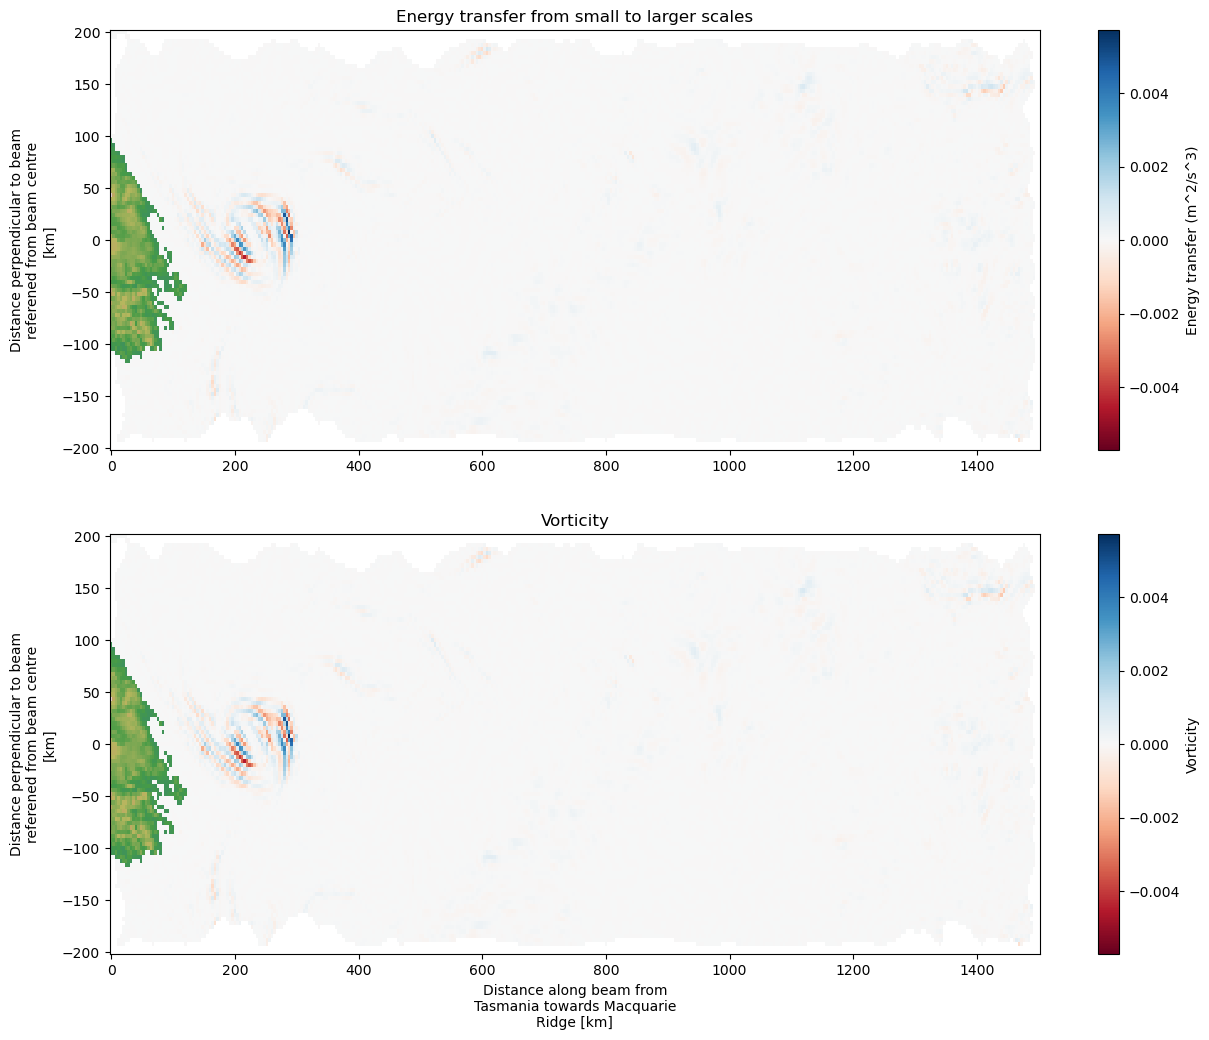

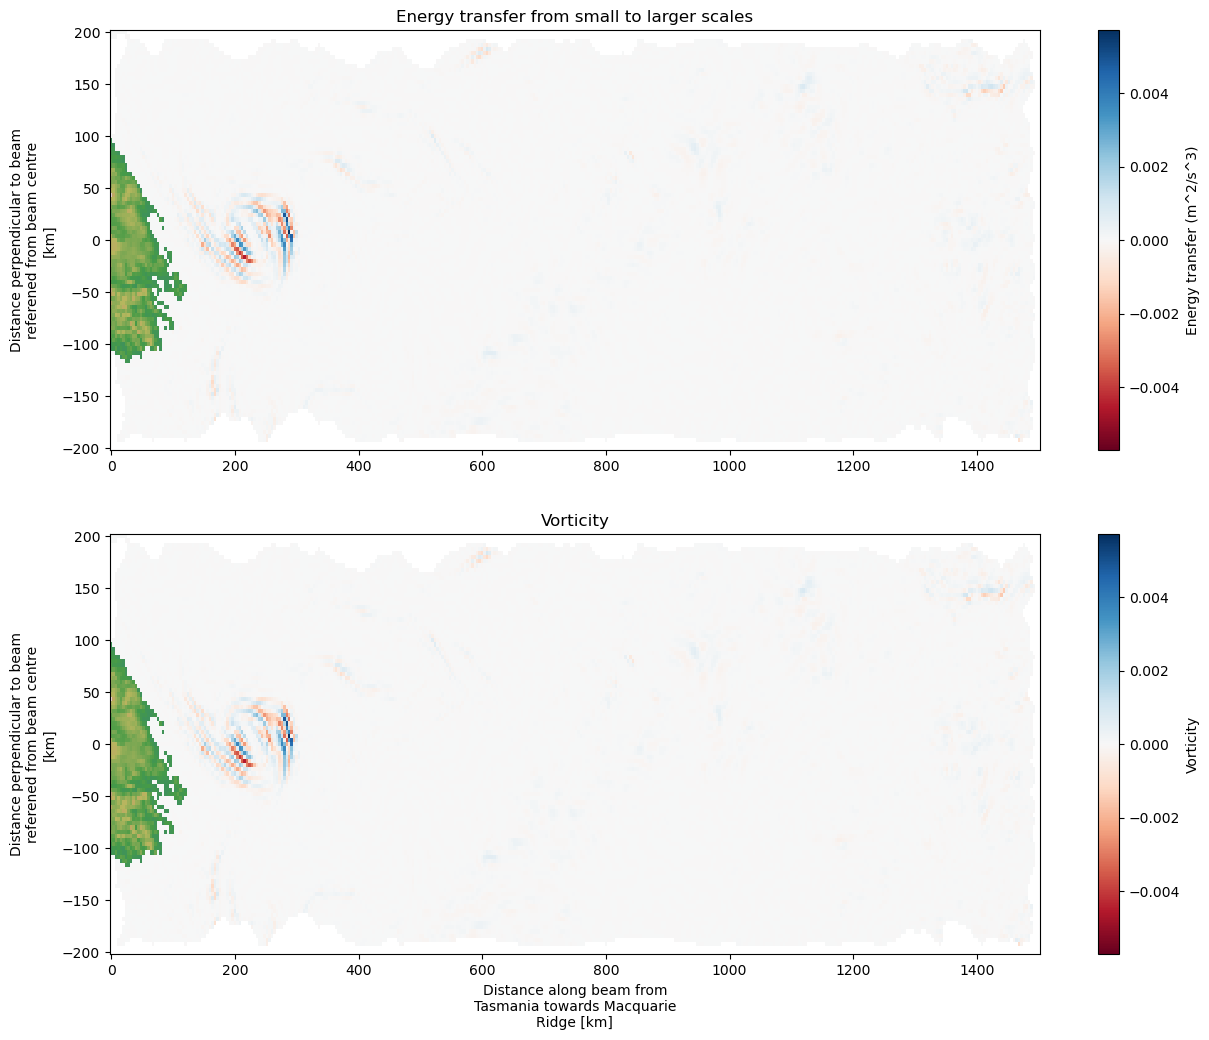

In [75]:
def cross_scale_transfer(data):

    if "zl" in data.dims:
        dims = ["time","zl","yb","xb"]
    else:
        dims = ["time","yb","xb"]


    tau_uu = data.uu - data.u**2
    tau_uv = data.uv - data.u*data.v
    tau_vv = data.vv - data.v**2
    u = data.u
    v = data.v
    uu = data.uu
    vv = data.vv



    transfer = (
        tau_uu * u.differentiate("xb") +
        tau_uv * u.differentiate("yb") +
        tau_uv * v.differentiate("xb") +
        tau_vv * v.differentiate("yb")
    ).rename("energy_transfer")



    return transfer

def plot_transfer(data,vmax = 0.1):
    """
    data needs to contain bathy, energy transfer, b"""
    cmap = matplotlib.cm.get_cmap("RdBu")
    fig,ax = plt.subplots(2,figsize = (15,12))
    # Set the background colour to the plot to the lowest value in the cmap
    ax[0].set_facecolor("white")
    ax[1].set_facecolor("white")
    
    # data.energy_transfer.plot(ax = ax[0],cmap = cmap,add_colorbar = True,vmax = vmax,vmin = -vmax,cbar_kwargs={'label': "Energy transfer (m^2/s^3)"})
    data.energy_transfer.plot(ax = ax[0],cmap = cmap,add_colorbar = True,cbar_kwargs={'label': "Energy transfer (m^2/s^3)"})
    data.vorticity.plot(ax = ax[1],cmap = cmap,add_colorbar = True,cbar_kwargs={'label': "Vorticity"})

    data.bathy.plot(cmap = earth_cmap,vmin = -1000,vmax = 1500,ax = ax[0],add_colorbar = False)
    data.bathy.plot(cmap = earth_cmap,vmin = -1000,vmax = 1500,ax = ax[1],add_colorbar = False)

    ax[0].set_xlabel("")
    ax[0].set_title(f"Energy transfer from small to larger scales")
    ax[1].set_title(f"Vorticity")
    plt.show()
    return fig

data = xr.open_dataset(outpath + ".nc")

data = data.assign_coords({
    "time":data.time / 3600,
    "xb":data.xb / 1000,
    "yb":data.yb / 1000})

bathy = xr.open_dataset("/g/data/nm03/ab8992/outputs/full-20/bathy_transect.nc").elevation
bathy = bathy.where(bathy > 0).rename("bathy").drop_vars("lon").drop_vars("lat")
data.xb.attrs = bathy.xb.attrs
data.yb.attrs = bathy.yb.attrs

for i in data.data_vars:
    data = data.rename({i:i.split("_")[1].lower()})


cst = cross_scale_transfer(data)
vorticity = tt.calculate_vorticity(rawdata).rename("vorticity")
merged = xr.merge([cst,bathy,cst.rename("vorticity")])

plot_transfer(merged.isel(time = 7))


In [67]:
merged

<xarray.Dataset>
Dimensions:    (time: 211, xb: 751, yb: 201)
Coordinates:
  * time       (time) float64 4.49e+04 4.49e+04 4.49e+04 ... 1.62e+08 1.62e+08
  * xb         (xb) float64 -0.0 4.0 8.0 12.0 ... 1.492e+06 1.496e+06 1.5e+06
  * yb         (yb) float64 -2e+05 -1.96e+05 -1.92e+05 ... 1.96e+05 2e+05
    zl         float64 30.17
Data variables:
    u          (time, yb, xb) float32 nan nan nan nan nan ... nan nan nan nan
    v          (time, yb, xb) float32 nan nan nan nan nan ... nan nan nan nan
    vv         (time, yb, xb) float32 nan nan nan nan nan ... nan nan nan nan
    uu         (time, yb, xb) float32 nan nan nan nan nan ... nan nan nan nan
    uv         (time, yb, xb) float32 nan nan nan nan nan ... nan nan nan nan
    bathy      (yb, xb) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    vorticity  (time, yb, xb) float32 dask.array<chunksize=(211, 6, 751), meta=np.ndarray>